1. 상단 메뉴 -> 런타임-> 런타임 유형 변경 -> GPU
2.  transformers 설치
3. Reviews.csv 업로드

In [1]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!wget -O Reviews.csv https://www.dropbox.com/s/igsnbo24jifkdjr/Reviews_mini.csv?dl=0


--2021-10-14 06:37:54--  https://www.dropbox.com/s/igsnbo24jifkdjr/Reviews_mini.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/igsnbo24jifkdjr/Reviews_mini.csv [following]
--2021-10-14 06:37:54--  https://www.dropbox.com/s/raw/igsnbo24jifkdjr/Reviews_mini.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbac30d9c706aac25b548b27c59.dl.dropboxusercontent.com/cd/0/inline/BYBBKW_qaKSW7mO1MGLerEAbwH9yO4lUWoxQG2prGvZ9UqRE0UUNuUZdhS-cUhBY1N-PyQQ0M8sbitGjPT_DcFCCWF8C44S7cYftvUpdtqn19xmusvnK0BeWKKqboIJxL7XBIJt7hNH64hKq33G_jAoh/file# [following]
--2021-10-14 06:37:54--  https://ucbac30d9c706aac25b548b27c59.dl.dropboxusercontent.com/cd/0/inline/BYBBKW_qaKSW7mO1MGLerEAbwH9yO4lUWoxQG2prGvZ9UqRE0UUNuUZdhS-cUhBY1N-PyQQ0M

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import csv
import torchtext
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score as ACC
from torch.nn.utils.rnn import pad_sequence
import numpy as np

In [4]:
df=pd.read_csv('Reviews.csv',error_bad_lines=False, engine="python")

In [5]:
df = df[['Score','Text']]

In [6]:
df

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
...,...,...
4995,2,I really wanted to like these.<br /><br />Firs...
4996,1,I was not impressed with these cookies when I ...
4997,3,The cookies came sealed and seem to be high qu...
4998,4,"These taste very good, but aren't like the BES..."


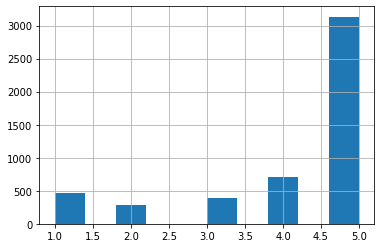

In [7]:
df['Score'].hist()

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [10]:
example_sentence = df['Text'].iloc[0]
example_sentence

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [11]:
tokenizer.encode(example_sentence)

[101,
 1045,
 2031,
 4149,
 2195,
 1997,
 1996,
 8995,
 3012,
 27141,
 3899,
 2833,
 3688,
 1998,
 2031,
 2179,
 2068,
 2035,
 2000,
 2022,
 1997,
 2204,
 3737,
 1012,
 1996,
 4031,
 3504,
 2062,
 2066,
 1037,
 20717,
 2084,
 1037,
 13995,
 6240,
 1998,
 2009,
 14747,
 2488,
 1012,
 2026,
 18604,
 2003,
 10346,
 6799,
 2100,
 1998,
 2016,
 9120,
 2015,
 2023,
 4031,
 2488,
 2084,
 2087,
 1012,
 102]

In [12]:
class textDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['Text'].iloc[idx]
        score = self.data['Score'].iloc[idx]

        encoded_text = self.tokenizer.encode(text)

        encoded_text = torch.tensor(encoded_text).long()
        score = torch.tensor(score).long()
        score = score-1 # 1~5->0~4
        return encoded_text, score

In [13]:
split_idx = int(len(df)*0.9)
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

In [14]:
batch_size = 4
device = torch.device('cuda')

# Data set
train_dataset = textDataset(train_data, tokenizer)
test_dataset = textDataset(test_data, tokenizer)

def collate_fn(batch):
  texts, scores = zip(*batch)
  texts_pad = pad_sequence(texts, batch_first=True, padding_value=0)
  texts_pad = texts_pad[:,:512]
  return texts_pad, torch.stack(scores)

# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)


In [24]:
class simpleRNN(nn.Module):
  def __init__(self):
        super(simpleRNN, self).__init__()

        self.embedding_layer = nn.Embedding(30522, embedding_dim=256)
        
        self.num_layers = 2
        self.RNN = nn.LSTM(256, 256, num_layers=self.num_layers, dropout=0.1, batch_first=True)
        
        self.out = nn.Linear(256, 5)

      
  def forward(self, text):
    # 1. 입력 text
    # - [[1,2,403,...,0,0,0]] 이렇게 생긴게 여러 개 / 단어의 인덱스들 집합
    # -word index가 입력되면 해당 word의 vector를 내뱉음
        x=self.embedding_layer(text)
        c0 = torch.zeros(self.num_layers,x.shape[0],256)
        h0 = torch.zeros(self.num_layers,x.shape[0],256)
        if torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
        x, h = self.RNN(x, (h0,c0))
        x = self.out(x[:,-1,:])


        return x

In [30]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.bert = BertForSequenceClassification.from_pretrained(options_name, num_labels=5)

    def forward(self, text):
        x = self.bert(text)[0]

        return x

In [31]:
learning_rate = 1e-5
model = BERT()
# model = simpleRNN()
if torch.cuda.is_available():
  model = model.cuda()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.bert.classifier.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
EPOCHS=2

losses = []
for epoch in range(EPOCHS):
    loss_list = []
    acc_list = []

    loss_list2 = []
    acc_list2 = []
    for i, (X_batch, y_batch) in enumerate(train_loader):
        if torch.cuda.is_available():
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        #Forward 
        y_output = model(X_batch)
        loss = criterion(y_output, y_batch) #CELoss: The input is expected to contain raw, unnormalized scores for each class.
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #misc (acc 계산, etc) 
        y_pred = torch.max(y_output, 1)[1]
        acc = ACC(y_batch.data.cpu(), y_pred.data.cpu())
        loss_list.append(loss.item())
        acc_list.append(acc)
        loss_list2.append(loss.item())
        acc_list2.append(acc)
        losses.append(loss.item())
        if (i+1) % 20 == 0:
            print('Epoch [{}/{}] Step [{}/{}] Loss: [{:.4f}] Train ACC [{:.2f}%]'.format(epoch+1, EPOCHS, \
                                                                                       i+1, len(train_loader), np.mean(loss_list2), np.mean(acc_list2)*100))
            loss_list2 = []
            acc_list2 = [] 
    print('Epoch [{}/{}] Loss: [{:.4f}] Train ACC [{:.2f}%]'.format(epoch+1, EPOCHS, np.mean(loss_list), np.mean(acc_list)*100))

Epoch [1/2] Step [20/1125] Loss: [1.3338] Train ACC [53.75%]


Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


Epoch [1/2] Step [40/1125] Loss: [1.2309] Train ACC [57.50%]


Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Epoch [1/2] Step [60/1125] Loss: [1.0053] Train ACC [71.25%]
Epoch [1/2] Step [80/1125] Loss: [1.1401] Train ACC [65.00%]
Epoch [1/2] Step [100/1125] Loss: [1.2174] Train ACC [60.00%]
Epoch [1/2] Step [120/1125] Loss: [1.2866] Train ACC [57.50%]
Epoch [1/2] Step [140/1125] Loss: [1.1961] Train ACC [60.00%]
Epoch [1/2] Step [160/1125] Loss: [0.9515] Train ACC [73.75%]
Epoch [1/2] Step [180/1125] Loss: [1.2224] Train ACC [60.00%]
Epoch [1/2] Step [200/1125] Loss: [1.0479] Train ACC [66.25%]
Epoch [1/2] Step [220/1125] Loss: [1.0212] Train ACC [70.00%]
Epoch [1/2] Step [240/1125] Loss: [1.1049] Train ACC [65.00%]
Epoch [1/2] Step [260/1125] Loss: [1.0333] Train ACC [68.75%]
Epoch [1/2] Step [280/1125] Loss: [1.2492] Train ACC [53.75%]
Epoch [1/2] Step [300/1125] Loss: [1.1303] Train ACC [63.75%]
Epoch [1/2] Step [320/1125] Loss: [0.9929] Train ACC [68.75%]
Epoch [1/2] Step [340/1125] Loss: [0.9643] Train ACC [73.75%]
Epoch [1/2] Step [360/1125] Loss: [1.1684] Train ACC [61.25%]
Epoch [1/2

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


Epoch [2/2] Step [20/1125] Loss: [0.7059] Train ACC [75.00%]
Epoch [2/2] Step [40/1125] Loss: [0.7739] Train ACC [71.25%]
Epoch [2/2] Step [60/1125] Loss: [0.7444] Train ACC [71.25%]
Epoch [2/2] Step [80/1125] Loss: [0.6805] Train ACC [73.75%]
Epoch [2/2] Step [100/1125] Loss: [0.6070] Train ACC [81.25%]
Epoch [2/2] Step [120/1125] Loss: [0.7206] Train ACC [72.50%]
Epoch [2/2] Step [140/1125] Loss: [0.5814] Train ACC [81.25%]
Epoch [2/2] Step [160/1125] Loss: [0.6691] Train ACC [80.00%]


Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


Epoch [2/2] Step [180/1125] Loss: [0.7000] Train ACC [73.75%]
Epoch [2/2] Step [200/1125] Loss: [0.6961] Train ACC [71.25%]
Epoch [2/2] Step [220/1125] Loss: [0.6159] Train ACC [77.50%]
Epoch [2/2] Step [240/1125] Loss: [0.5906] Train ACC [72.50%]
Epoch [2/2] Step [260/1125] Loss: [0.5833] Train ACC [73.75%]
Epoch [2/2] Step [280/1125] Loss: [0.6204] Train ACC [71.25%]
Epoch [2/2] Step [300/1125] Loss: [0.6482] Train ACC [77.50%]
Epoch [2/2] Step [320/1125] Loss: [0.5517] Train ACC [77.50%]
Epoch [2/2] Step [340/1125] Loss: [0.5994] Train ACC [73.75%]
Epoch [2/2] Step [360/1125] Loss: [0.8209] Train ACC [67.50%]
Epoch [2/2] Step [380/1125] Loss: [0.6558] Train ACC [75.00%]
Epoch [2/2] Step [400/1125] Loss: [0.7132] Train ACC [76.25%]
Epoch [2/2] Step [420/1125] Loss: [0.7095] Train ACC [70.00%]
Epoch [2/2] Step [440/1125] Loss: [0.6398] Train ACC [76.25%]
Epoch [2/2] Step [460/1125] Loss: [0.6937] Train ACC [76.25%]
Epoch [2/2] Step [480/1125] Loss: [0.6905] Train ACC [71.25%]
Epoch [2

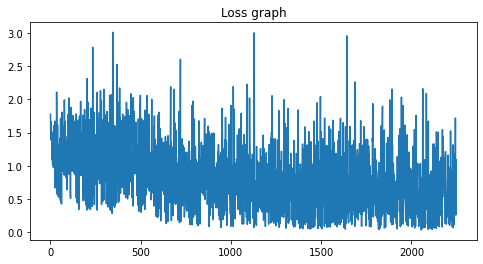

In [33]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title('Loss graph')
plt.show()

In [34]:
test_acc_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:    
        if torch.cuda.is_available():
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        y_output = model(X_batch)
        y_pred = torch.max(y_output, 1)[1]
        
        acc = ACC(y_batch.data.cpu(), y_pred.data.cpu())
        test_acc_list.append(acc)
    test_acc = np.mean(test_acc_list)
print('Test ACC: [{:.2f}%]'.format(test_acc*100))

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


Test ACC: [67.00%]


# 과제

63% accuracy를 달성해보세요! (Hint: BERT를 낮은 learning rate로 학습해보세요.)